# Future Network Constrained Linear Optimal Power Flow - with Floating Wind & Marine, and Emissions Modelling

## Overview

In this notebook, floating wind, wave power, tidal stream and tidal lagoon are considered specifically.  After the optimisation, the greenhouse gas emissions of the period under consideration are calculated for the whole grid, and for each node.

The emissions calculation relies on emissions intensity factors for each type of generation - due to the signficant differences between certain types within a carrier.  This input data is provided from literature review.

## Setup

### Environments and Modules

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import string
import numpy as np

import data_reader_writer
import generators

### Defining the Simulation Period

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [3]:
# write csv files for import
start = '2050-02-27 00:00:00'
end = '2050-03-01 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour (default set to one hour to reduce computation)
time_step = 1.0

### Selecting the Future Energy Scenario

Choose from one of the National Grid Future Energy Scenarios.

In [4]:
# scenario = 'Consumer Transformation'
scenario = 'Leading The Way'
# scenario = 'Steady Progression'
# scenario = 'System Transformation'

Choose a baseline year (from 2010-2020). The baseline year determines which historical load profile and weather dataset is used for the future year modelled. The National Grid FES modellers used 2012 as their baseline year.

In [5]:
year_baseline = 2012

In [6]:
# # create scenario file naming convention for saving outputs later
# SC = ''.join(c for c in scenario if c.isupper())
# s = SC + start + end + str(year_baseline)
# for char in string.punctuation:
#     s = s.replace(char,'')
#     s = s.replace(" ",'')
# filename = s + '.png'
# powername = s + '_power.csv'
# print(filename)
# print(powername)

# need to set up figures for power, emissions, map...


In [7]:
# path = r'C:\Users\s1100626/OneDrive - University of Edinburgh\Year 2 - Energy System Modelling\Q4 - Results\Results'
# fullpath = os.path.join(path, filename)

In [8]:
if year >= 2040:
    demand_dataset = 'eload'
else:
    demand_dataset = 'historical' 
data_reader_writer.data_writer(start, end, time_step, year, demand_dataset=demand_dataset, year_baseline=year_baseline,
                               scenario=scenario, FES=2022,  merge_generators=True, marine_modify=True, marine_scenario='Low')

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:206: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]


## Running the Optimisation

Here we can introduce new marine scenarios

In [9]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, links, loads, storage_units


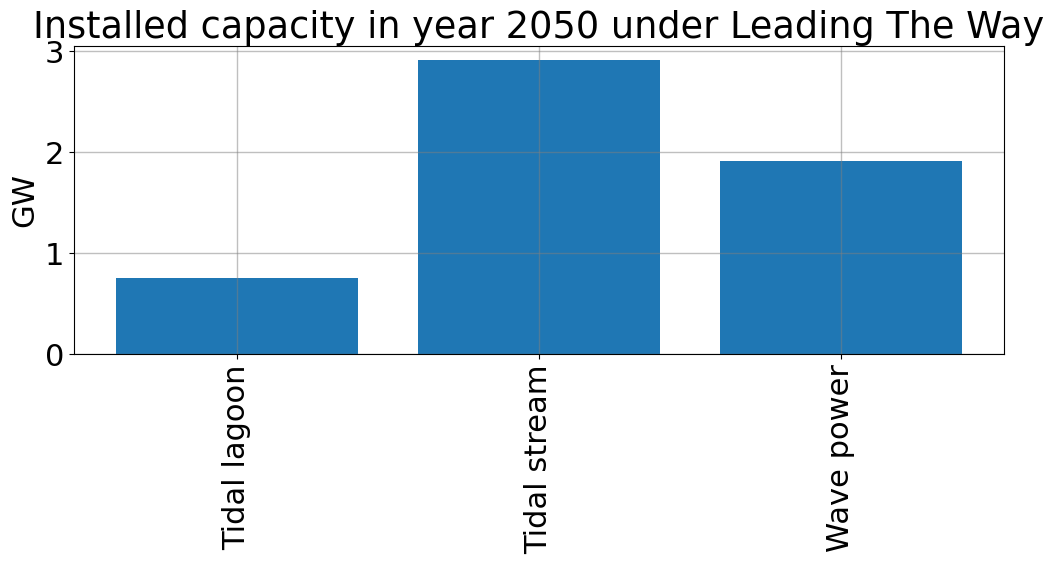

In [10]:
df_generators = network.generators
generators_p_nom = df_generators.p_nom.groupby(
    df_generators.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom.drop('Unmet Load', inplace=True)
marine = generators_p_nom.loc[['Tidal lagoon', 'Tidal stream', 'Wave power']]

plt.rcParams.update({'font.size': 22})
# bar chart
plt.figure(figsize=(12,4))
plt.bar(marine.index, marine.values / 1000)
plt.xticks(marine.index, rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Installed capacity in year ' + str(year) + ' under ' + scenario)
plt.show()

In [11]:
print(marine)

carrier
Tidal lagoon     749.0
Tidal stream    2910.0
Wave power      1910.0
Name: p_nom, dtype: float64


Lines need to be scaled up to accommodate for future generation. An arbitrary value of 4 is selected.

In [12]:
contingency_factor = 4
network.lines.s_max_pu *= contingency_factor

In [13]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.94s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-1sociveb.lp
Reading time = 0.32 seconds
obj: 195038 rows, 59257 columns, 343329 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 195038 rows, 59257 columns and 343329 nonzeros
Model fingerprint: 0x9141a7ee
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-04, 1e+09]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 184676 rows and 26155 columns
Presolve time: 0.12s
Presolved: 10362 rows, 33528 columns, 64745 nonzeros

Ordering time: 0.08s

Barrier statistics:
 AA' NZ     : 2.897e+04
 Factor NZ  : 4.812e+05 (roughly 20 MB of memory)
 Factor Ops : 5.969e+07 (less th

INFO:pypsa.linopf:Optimization successful. Objective value: 6.73e+14


('ok', 'optimal')

## Results

### Power by Generation Type

Real power output is interrogated by generation type.  The total contribution to the grid wide generation is reported over the simulation period.  Nodal contributions are analysed in the emissions modelling section.

Note that there is a difference in terminology between generators and storage types; it is storage carriers that are plotted, however they are described as storage 'types'.

In [14]:
# define dataframe containing time series of real power generated, arranged by generation and storage types
p_by_type = network.generators_t.p.groupby(network.generators.type, axis=1).sum()

# Combining Hydro types into a single category and removing 
p_by_type['Hydro'] = (p_by_type['Small Hydro'] + p_by_type['Large Hydro'])

p_by_type.drop('Small Hydro', axis=1, inplace=True)
p_by_type.drop('Large Hydro', axis=1, inplace=True)

# Combining Diesel/Gas oil types into a single category and removing 
p_by_type['Diesel'] = (p_by_type['Diesel/Gas oil'] + p_by_type['Diesel/gas Diesel/Gas oil'])

p_by_type.drop('Diesel/Gas oil', axis=1, inplace=True)
p_by_type.drop('Diesel/gas Diesel/Gas oil', axis=1, inplace=True)

# Combining Nuclear types into a single category and removing 
p_by_type['Nuclear'] = (p_by_type['AGR'] + p_by_type['PWR'])

p_by_type.drop('AGR', axis=1, inplace=True)
p_by_type.drop('PWR', axis=1, inplace=True)

# Sorting generation types alphabetically
p_by_type = p_by_type[sorted(p_by_type.columns)]

# concatenating storage types
storage_by_type = network.storage_units_t.p.groupby(network.storage_units.carrier, axis=1).sum()
p_by_type = pd.concat([p_by_type, storage_by_type], axis=1)

# Including Interconnectors Import
imp = network.links_t.p0.copy()
imp[imp < 0] = 0
imp['Interconnectors Import'] = imp.sum(axis=1)
interconnector_import = imp[['Interconnectors Import']]
p_by_type = pd.concat([p_by_type, interconnector_import], axis=1)

# Including Interconnectors Export (note that post-processing occurs later in script)
exp = network.links_t.p0.copy()
exp[exp > 0] = 0
exp['Interconnectors Export'] = exp.sum(axis=1)
interconnector_export = exp[['Interconnectors Export']]

# Renaming Interconnector Import
p_by_type = p_by_type.rename(columns={'Interconnector': 'Interconnectors Import'})

In [15]:
# Removing columns where generation is zero
p_by_type = p_by_type.loc[:, p_by_type.any()]

In [16]:
# Setting all negative generation values to zero
p_by_type[p_by_type < 0] = 0 # ideally stacked area chart would show all generation and charging

In [17]:
# Define colors for each generation/storage/interconnector type (note that Interconnector Export colour not defined in this way)

colors = {'Anaerobic Digestion': 'darkgoldenrod',
          'Biomass (co-firing)': 'yellowgreen',
          'Biomass (dedicated)': 'olivedrab',
          'CCGT': 'red',
          'CCS Biomass': 'darkolivegreen',
          'CCS Gas': 'lightcoral',
          'Diesel': 'lightgrey',
          'EfW Incineration': 'chocolate',
          'Floating Wind': 'royalblue',
          'Hydro': 'teal',
          'Hydrogen': 'paleturquoise',
          'Landfill Gas': 'olive',
          'Nuclear': 'lime',
          'OCGT': 'red',
          'Sewage Sludge Digestion': 'saddlebrown',
          'Solar Photovoltaics': 'yellow',
          'Tidal lagoon': 'mediumblue',
          'Tidal stream': 'midnightblue',
          'Unmet Load': 'black',
          'Wave power': 'steelblue',
          'Wind Offshore': 'cornflowerblue',
          'Wind Onshore': 'mediumseagreen',
          'Battery': 'mediumorchid',
          'Compressed Air': 'plum',
          'Liquid Air': 'thistle',
          'Pumped Storage Hydroelectric': 'deepskyblue',
          'Interconnectors Import': 'palevioletred'
         }

#           'Coal': 'dimgrey',
#           'Oil': 'red',
#           'Biomass': 'greenyellow',       
#           'Interconnectors Export': 'crimson',          
#           'Sour gas': 'darkred',
#           'Natural Gas': 'coral',
#           'Large Hydro': 'darkturquoise',
#           'Small Hydro': 'turquoise',

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

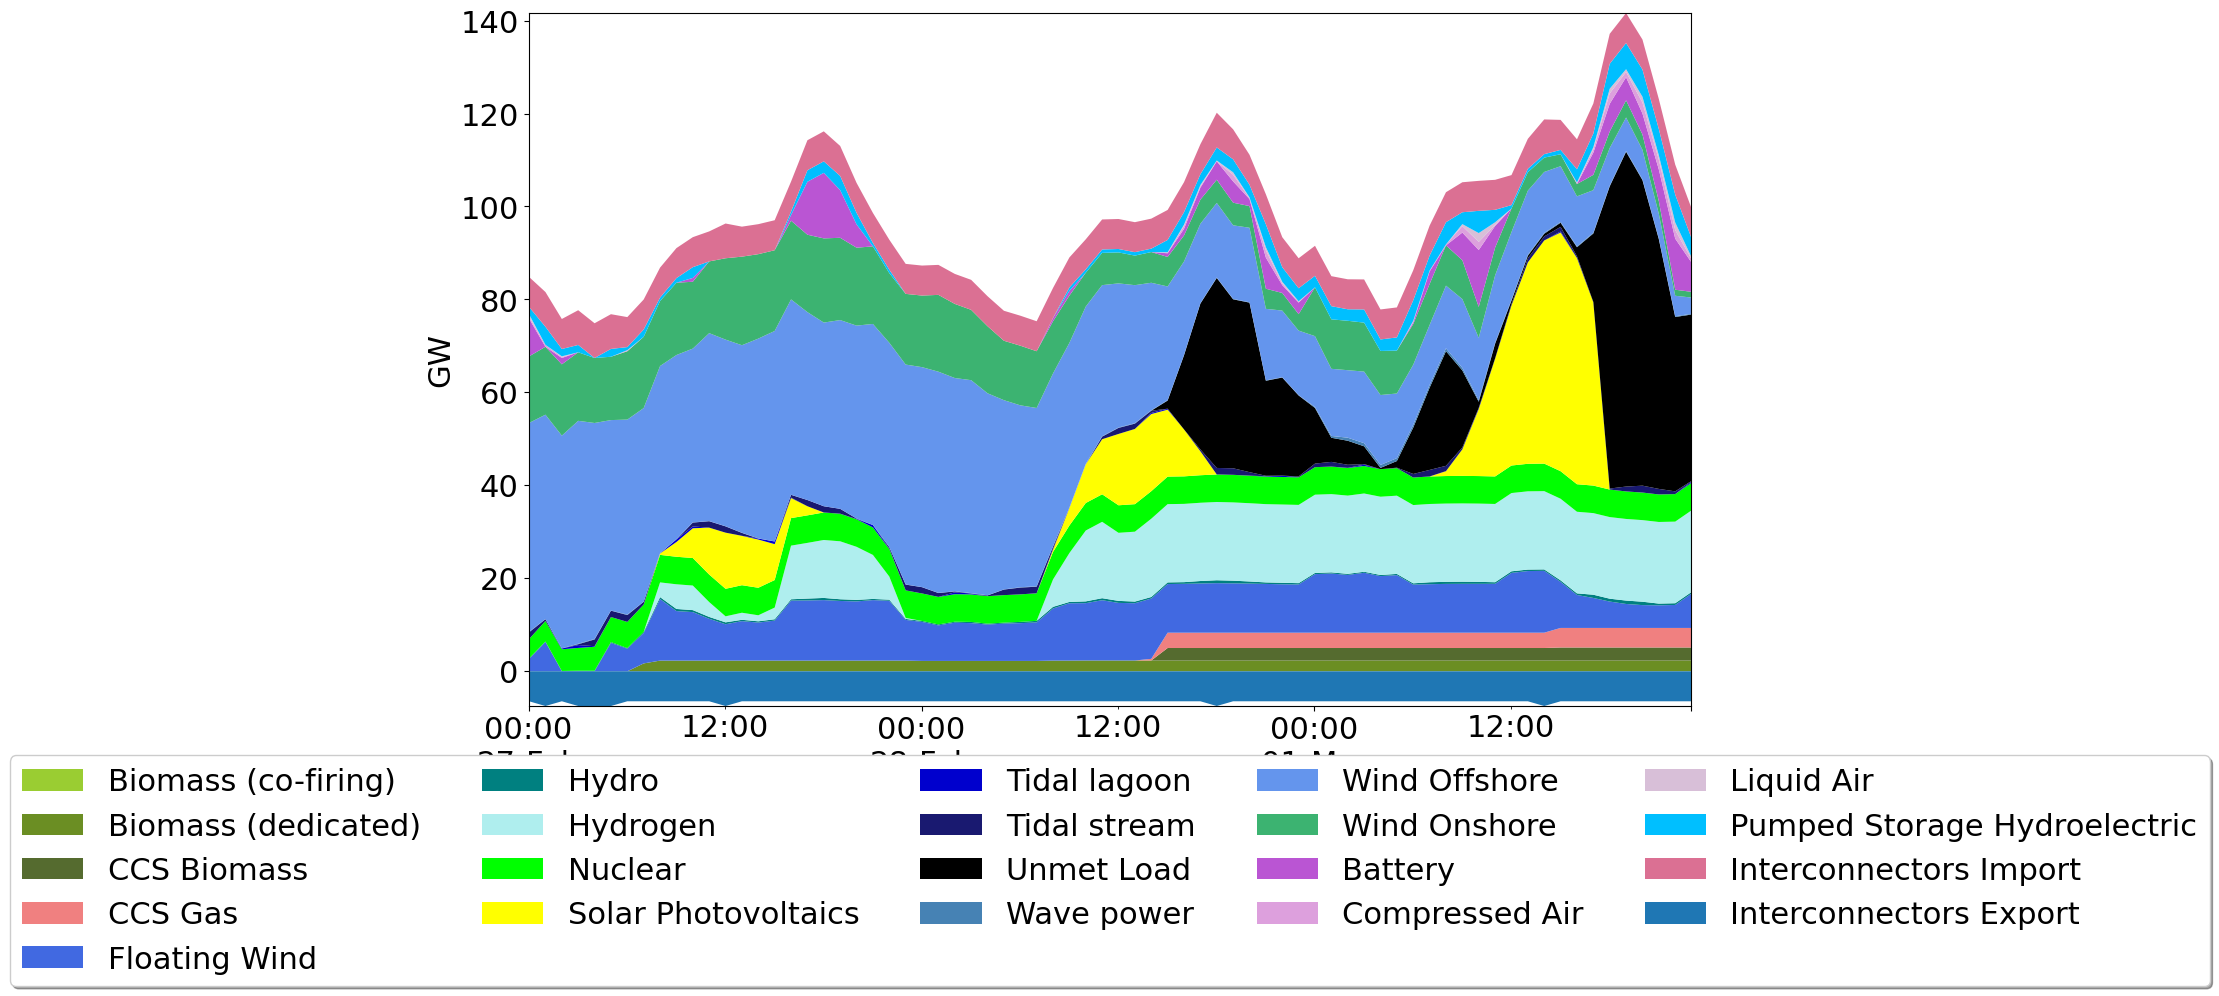

In [18]:
# Plot network-wide generation time series by generation type
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_type / 1e3).plot(
    kind='area', ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_type.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)

# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_type / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.set_ylabel('GW')
ax.set_xlabel('')

### Emissions by Generation Type (including Interconnectors)

This section calculates a time series of emissions from each generation type according to the real power time series calculated in the previous section.  Note that these data include the emissions from interconnection, which is an important consideration - whether gross emissions from GB power sector include continental emissions.

In [19]:
 # arrange p_by_type columns into alphabetical order to ensure consistency with EI factors
p_by_type = p_by_type[sorted(p_by_type.columns)]

# create a numpy array from a list of generation types, from top row of generation mix dataframe
types = np.asarray(list(p_by_type.columns.values))

# reading in the emissions intensity data contained in relevant .csv as a dataframe
emissions_intensity = pd.read_csv('emissions_intensity_by_types.csv')
emissions_intensity_LOPF = emissions_intensity[emissions_intensity['Type'].isin(types)]
emissions_intensity_LOPF.sort_values('Type')
EI_factors = emissions_intensity_LOPF['Emissions Intensity [gCO2/kWh]'].to_numpy()

# Create energy generation mix dataframe by multiplying power generation mix by the time step [MWh]
E_by_type = p_by_type.multiply(time_step)

# Create emissions dataframe. Multiply all columns in the energy dataframe by the numpy array of emissions intensity factors
Emit_by_type = E_by_type.multiply(EI_factors, axis=1)

# Convert gCO2/kWh * MWh to teCO2; the quotient of kWh:MWh (1e3) and gCO2:teCO2 (1e6) = 1e3
Emit_by_type_te = Emit_by_type.div(1e3)
Emit_by_type_te = Emit_by_type_te.loc[:, Emit_by_type_te.any()]
Emit_by_type_te.to_csv('Emit_by_type_te.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'emissions_intensity_by_types.csv'

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(Emit_by_type_te).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in Emit_by_type_te.columns])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("tonne CO2")
ax.set_xlabel("")

### Emissions Intensity (including Interconnectors)

A time series of the network-wide (including continental interconnectors) emissions intensity is determined below.  This is repeated later in the notebook, but excludes interconnectors.

In [ ]:
# Time series of total emissions in tonnes (sum of emissions from all types - including interconnectors unless explicitly modified)
Total_Emit_t_te = Emit_by_type_te.sum(axis=1)

# Energy delivered to the grid at each time step
Total_E_t = E_by_type.sum(axis=1)

# The grid-wide emissions intensity in gCO2/kWh at each time step is given by:
EI_gCO2 = Total_Emit_t_te * 1e3 / Total_E_t
EI_gCO2.to_csv('EI_gCO2.csv')

#### Average Emissions Intensity (including Interconnectors)

In [ ]:
# Average emissions intensity over the period, method 1 = quotient of sums:
EI_avg_gCO2 = 1e3 * sum(Total_Emit_t_te) / sum(Total_E_t)
print("Average emissions intensity over the period, Method 1 = ", EI_avg_gCO2, "gCO2/kWh")

# Average emissions intensity over the period, method 2 = mean of dataframe:
print("Average emissions intensity over the period, Method 2 = ", EI_gCO2.mean(), "gCO2/kWh")

### Emissions by Node (excluding Interconnectors)

The emissions intensity arising at each node can be calculated by inspection of the generation mix at each node.

In [ ]:
# The main data originates from a pypsa network object: real power time series from each generator before node aggregation
power_t_by_generator = network.generators_t.p

# Create a list of generators and their <bus>/<types>, in the same sequence as above
generators_by_bus = network.generators.bus
generators_by_type = network.generators.type
power_t_by_generator.loc[len(power_t_by_generator)] = generators_by_bus
power_t_by_generator.loc[len(power_t_by_generator)] = generators_by_type
power_t_by_generator.to_csv('power_t_by_generator.csv')

# NB: This treatment can require the kernal to be restarted if run (and therefore executes appending) multiple times.

In [ ]:
df = pd.read_csv('power_t_by_generator.csv')

# create new df for generator information (bus/type) only
loc_and_type = df.iloc[len(df.index) - 2:, :].T
loc_and_type['sitename'] = loc_and_type.index.values
loc_and_type.columns= ['location', 'type', 'sitename']
loc_and_type = loc_and_type[1:]

In [ ]:
# remove extant csv
os.remove('power_t_by_generator.csv')

In [ ]:
# remove site (bus/type) information from power data
df.drop(labels=[(len(df)-2),(len(df)-1)], axis=0, inplace=True)
long_table = pd.melt(df, id_vars='snapshot', var_name='sitename', value_name='power')
long_table = long_table.merge(loc_and_type, on='sitename')
long_table['power'] = pd.to_numeric(long_table['power'])

In [ ]:
grouped = long_table.groupby(by=['snapshot', 'location', 'type']).sum()
grouped = grouped.reset_index(level=0)
grouped = grouped.reset_index(level=0)
grouped = grouped.reset_index(level=0)
wide_table_0 = grouped.pivot(index='snapshot', columns=['location', 'type'])['power']
wide_table_0.to_csv('wide_table_0.csv')

In [ ]:
# remove types (columns) where no real power is generated
wide_table = grouped.pivot(index='snapshot', columns=['location', 'type'])['power']
wide_table.drop(columns=wide_table.columns[wide_table.sum()==0], inplace=True)
wide_table.to_csv('wide_table.csv')

In [ ]:
# create a dataframe of emissions intensity data by reading in the emissions intensity data contained in relevant .csv
emissions_intensity = pd.read_csv('emissions_intensity_by_types.csv')
emissions_intensity.columns = ['Type', 'EI']

In [ ]:
# get vector of all the types for the full dataset
df2 = wide_table.columns
types_full = df2.get_level_values(1)
types_full = pd.DataFrame(types_full.values)
types_full.columns =['Types']

In [ ]:
# create long list of all emissions intensity ordered by the real power generation table
EI_full = types_full.replace(dict(zip(emissions_intensity.Type, emissions_intensity.EI)))
EI_full = EI_full.squeeze()

In [ ]:
# Create energy generation mix dataframe by multiplying power generation mix by the time step [MWh]
E_by_type_node = wide_table.multiply(time_step)
E_by_type_node_0 = wide_table_0.multiply(time_step)

In [ ]:
# All emissions, including types (and locations) with zero emissions
emis_0 = pd.DataFrame(E_by_type_node.values*EI_full.values, columns=E_by_type_node.columns, index=E_by_type.index)

In [ ]:
# remove types (columns) with zero emissions
emis = emis_0
emis.drop(columns=emis.columns[emis.sum()==0], inplace=True)
emis_bus = emis.T

In [ ]:
# sum emissions by type at each location
emis_bus = emis_bus.groupby(by=['location']).sum()
emis_bus = emis_bus.T

In [ ]:
# Convert gCO2/kWh * MWh to teCO2; the quotient of kWh:MWh (1e3) and gCO2:teCO2 (1e6) = 1e3
emis_by_bus_te = emis_bus.div(1e3)
emis_by_bus_te.to_csv('emis_by_bus_te.csv')

In [ ]:
# plot how the emissions in tonnes changes at each node in time - no interconnectors, hence different to previous treatment
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(emis_by_bus_te).plot(
    kind="area", ax=ax, linewidth=0)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("tonne CO2")
ax.set_xlabel("")

### Emissions Intensity (excluding Interconnectors)

In [ ]:
# Total grid-wise emissions in tonnes of grid at each time step, excluding interconnectors
emis_te_ex_int = emis_by_bus_te.sum(axis=1)

# Grid-wise energy delivered at each time step
E_ex_int = E_by_type.drop(columns = 'Interconnectors Import')
E_ex_int = E_ex_int.sum(axis=1)

# casting new index to ensure compatibility for division
emis_te_ex_int.index = E_ex_int.index

# The grid-wide emissions intensity in gCO2/kWh at each time step is given by:
EI_gCO2_ex_int = emis_te_ex_int * 1e3 / E_ex_int
EI_gCO2_ex_int.to_csv('EI_gCO2_ex_int.csv')

#### Average Emissions Intensity (excluding Interconnectors)

In [ ]:
# Average emissions intensity over the period, method 1 = quotient of sums:
EI_gCO2_ex_int_avg = 1e3 * sum(emis_te_ex_int) / sum(E_ex_int)
print("Method 1 = ", EI_gCO2_ex_int_avg, "gCO2/kWh")

# Average emissions intensity over the period, method 2 = mean of dataframe:
print("Method 2 = ", EI_gCO2_ex_int.mean(), "gCO2/kWh")

#### Nodal Emissions Intensity (excluding Interconnectors)

The emissions intensity at each location can be considered per time step, or averaged over the period.  The variation in emissions intensity is plotted in time at each node.

In [ ]:
# sum energy by type at each node [MWh]
E_by_node = E_by_type_node.T
E_by_node = E_by_node.groupby(by=['location']).sum()
E_by_node = E_by_node.T

In [ ]:
# casting new index to ensure compatibility for division
E_by_node.index = emis_by_bus_te.index
E_by_node.to_csv('E_by_node.csv')

In [ ]:
# emissions intensity by node
EI_by_node = 1e3 * emis_by_bus_te  / E_by_node
EI_by_node.fillna(0, inplace=True) # set NaN to zero - created when emissions at a node don't appear because all nodal generation is zero emissions
EI_by_node['Average'] = EI_by_node.mean(axis=1) # create new column containing the average across all nodes
EI_by_node.to_csv('EI_by_node.csv')

In [ ]:
# plot how the emissions intensity in [gCO2/kWh] changes at each node in time (zero emissions intensity not shown)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
EI_by_node.plot(ax = ax)

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
ax.set_ylabel("gCO2/kWh")
ax.set_xlabel("")

#### Average Nodal Emissions Intensity

The average emissions intensity over the period at each location can be plotted to consider local emissions.  The variation in emissions intensity is plotted in time at each node.

In [ ]:
# defining a time stamp - note this is set up for the final time step, not an average value
# The time stamp 'now' is not critical though as 'network' object is constant within each run and average defined elsewhere
now = network.snapshots[len(emis_by_bus_te)-1] 

# required order of buses for plotting on map is given by network object:
bus_order = network.buses_t.marginal_price.loc[now] # type = series.
bus_order = bus_order[:].index
frame = { 'location': bus_order }
bus_order_df = pd.DataFrame(frame)

In [ ]:
# calculating gross emissions at all buses (including zero emission buses) in tonnes
emis_0_bus = emis_0.T
emis_0_bus = emis_0_bus.groupby(by=['location']).sum()
emis_0_bus = emis_0_bus.T
emis_0_by_bus_te = emis_0_bus.div(1e3) #; emis_0_by_bus_te

In [ ]:
# sum energy by type at each node (including zero emission buses) in MWh
E_by_node_0 = E_by_type_node_0.T
E_by_node_0 = E_by_node_0.groupby(by=['location']).sum()
E_by_node_0 = E_by_node_0.T

In [ ]:
# casting new index to ensure compatibility for division
E_by_node_0.index = emis_0_by_bus_te.index

In [ ]:
# calculating average emissions intensity by node
EI_0_by_node = 1e3 * emis_0_by_bus_te  / E_by_node_0
EI_0_by_node.fillna(0) # set NaN to zero - created when emissions at a node don't appear because all nodal generation is zero emissions
EI_0_by_node['Average'] = EI_0_by_node.mean(axis=1) # create new column containing the average across all nodes

In [ ]:
# average emissions intensity at each bus over the period (series)
EI_0_by_node_avg = EI_0_by_node.mean()
EI_0_by_node_avg = EI_0_by_node_avg.drop(labels = 'Average')
EI_0_by_node_avg = EI_0_by_node_avg.fillna(0)
EI_0_by_node_avg = EI_0_by_node_avg.to_frame().reset_index()
EI_0_by_node_avg.columns = ['location', 'EI_avg']; 

# define EI at interconnectors (exogeneous)
interconnectors = pd.DataFrame({'location': ['Netherlands',
                                             'Belgium',
                                             'France1',
                                             'France2',
                                             'Ireland',
                                             'Germany',
                                             'Ireland2',
                                             'Norway',
                                             'Denmark'],
                    'EI_avg': [10, 10, 10, 10, 10, 10, 10, 10, 10]}) # test figures to check location

#add new row to end of DataFrame
EI_0_by_node_avg = EI_0_by_node_avg.append(interconnectors, ignore_index = True)

df_merge = pd.merge(bus_order_df, EI_0_by_node_avg, on=['location'])

In [ ]:
# creating figure
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=df_merge['EI_avg'],
           cmap=plt.cm.jet)

cb = plt.colorbar()
cb.set_label('Average emissions')